# TODO
1. Make find_neighborhood faster
1. Make a heat map of all calls, not just for those that can be binned in neighborhoods
1. Make a script containing functions for mapping/plotting that can be reused
1. Properly handle the reading/writing of segmented neightborhood df

# Call Center Exploratory Data Analysis I
## Overview
- Load cleaned call center data that was previously generated
- Add a `neighborhood` column that shows which neighborhood the request is in
- Look at the geospatial distribution of these events
    - Where are most happening?
    - Which areas have the most closed/open requests?
    - Which areas have receive attention the fastest?

In [1]:
# Standard tools for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Tools specific for geospatial data analysis
from mpl_toolkits.basemap import Basemap
import shapely
from shapely.geometry import shape, mapping, Point, Polygon
import geopandas as gpd
import geojsonio
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch

# Tools from the Python Standard Library
import os
import re

from IPython.display import display
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
RESULTSDIR = '../results/'
!ls $RESULTSDIR

01-air_quality.h5      01-neighborhoods.h5    02-service_requests.h5
01-crime.h5            01-service_requests.h5


Read in the DataFrame that was previously generated:

In [3]:
service_requests = pd.read_hdf(RESULTSDIR + '01-service_requests.h5')
service_requests.head()

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,STATUS,DATETIMECLOSED,coordinates,time_to_close,time_since_init
1,770584,2017-11-01 06:34:04,SeeClickFix,Parking - Enforcement,TRAFFIC_ENGIN,OPEN,NaT,"(37.78502, -122.221176)",NaT,20 days 17:25:56
2,770585,2017-11-01 07:22:20,SeeClickFix,"Graffiti on Street, Street Light, Traffic Signal,",GRAFFITI,WOCREATE,NaT,"(37.812325, -122.256729)",NaT,20 days 16:37:40
3,770586,2017-11-01 07:29:17,Website,Litter - Street Litter Container - Overflowing...,ILLDUMP,OPEN,NaT,"(37.791987, -122.213031)",NaT,20 days 16:30:43
4,770587,2017-11-01 07:29:18,Website,Litter - Street Litter Container - Overflowing...,ILLDUMP,CANCEL,NaT,"(37.791987, -122.213031)",NaT,20 days 16:30:42
5,770588,2017-11-01 07:30:42,SeeClickFix,Oakland Police - Abandoned Auto,OTHER,REFERRED,NaT,"(37.747044, -122.194686)",NaT,20 days 16:29:18


In [4]:
service_requests.shape

(399476, 10)

In [5]:
# Uncomment below to limit the number of entries to look at
# service_requests = service_requests[:80000]

Read in the neighborhood information:

In [6]:
DATADIR = '../data/'

In [7]:
neighborhoods = gpd.read_file(DATADIR + 'oakland_neighborhoods.geojson')

Drop the entries that are of type `Point`. The simplest method was just to check the transition from `Point` to `Polygon`.

In [27]:
neighborhoods = neighborhoods.iloc[137:]

In [28]:
neighborhoods.head()

,name,description,geometry,time_to_close,n_poop
137,Acorn/ Acorn Industrial,,"(POLYGON ((-122.280212520786 37.8025938890711,...",33.304501,5.0
138,Adams Point,,"(POLYGON ((-122.247844000895 37.810057515347, ...",29.097398,12.0
139,Allendale,,"(POLYGON ((-122.196320300415 37.7863349418319,...",23.385798,2.0
140,Arroyo Viejo,,"(POLYGON ((-122.170503431087 37.759584556553, ...",19.281956,39.0
141,Bancroft Business/ Havenscourt,,"(POLYGON ((-122.177112657994 37.7654884250132,...",21.010000,18.0


Now that we have only the shapes of these regions, we can determine which neighborhoods these requests are occuring in. Let's make a function to test which neighborhood a GPS coordinate is in:

In [ ]:
def find_neighborhood(coord, neighborhoods):
    
    # Reverse the coordinates since we plot them in (x, y) = (longitude, latitude), whereas GPS coordinates are
    # typically (latitude, longitude)
    coord = coord[::-1]
    
    for idx, neighborhood in neighborhoods.iterrows():
        try: 
            Point(coord).within(neighborhood['geometry'])
        except:
            return 'CONFLICT'
        if  Point(coord).within(neighborhood['geometry']):
            return neighborhood['name']
        
    return 'N/A'

Let's test this out:

In [ ]:
for coords in service_requests['coordinates'][:10]:
    print(find_neighborhood(coords, neighborhoods))

Cool! We can apply this to all entries in our `service_request` DataFrame and determine which neighborhood the requests are in. 

### Warning: this takes a long time.

In [ ]:
service_requests['neighborhood'] = service_requests['coordinates'].apply(lambda x: find_neighborhood(x, neighborhoods))

Let's save this in case we want to open it another time:

In [ ]:
service_requests.to_hdf(RESULTSDIR + '02-service_requests.h5', 'service_requests')

In [8]:
service_requests = pd.read_hdf(RESULTSDIR + '02-service_requests.h5')

In [9]:
service_requests.head()

,REQUESTID,DATETIMEINIT,SOURCE,DESCRIPTION,REQCATEGORY,STATUS,DATETIMECLOSED,coordinates,time_to_close,time_since_init,neighborhood
1,770584,2017-11-01 06:34:04,SeeClickFix,Parking - Enforcement,TRAFFIC_ENGIN,OPEN,NaT,"(37.78502, -122.221176)",NaT,20 days 17:25:56,Patten
2,770585,2017-11-01 07:22:20,SeeClickFix,"Graffiti on Street, Street Light, Traffic Signal,",GRAFFITI,WOCREATE,NaT,"(37.812325, -122.256729)",NaT,20 days 16:37:40,Adams Point
3,770586,2017-11-01 07:29:17,Website,Litter - Street Litter Container - Overflowing...,ILLDUMP,OPEN,NaT,"(37.791987, -122.213031)",NaT,20 days 16:30:43,Upper Peralta Creek/ Bartlett
4,770587,2017-11-01 07:29:18,Website,Litter - Street Litter Container - Overflowing...,ILLDUMP,CANCEL,NaT,"(37.791987, -122.213031)",NaT,20 days 16:30:42,Upper Peralta Creek/ Bartlett
5,770588,2017-11-01 07:30:42,SeeClickFix,Oakland Police - Abandoned Auto,OTHER,REFERRED,NaT,"(37.747044, -122.194686)",NaT,20 days 16:29:18,Coliseum Industrial


Let's group by neighborhood and get some descriptive statistics:

In [10]:
service_requests['neighborhood'].value_counts()[:10]

N/A               65486
Clawson            9435
Prescott           8021
Hoover/ Foster     7166
Longfellow         6678
Downtown           6608
McClymonds         5617
Adams Point        5525
Temescal           5120
Highland           4669
Name: neighborhood, dtype: int64

Most don't fall within our neighborhood segements...

## Distribution of response times

Let's look at the distribution of response times in units of days:

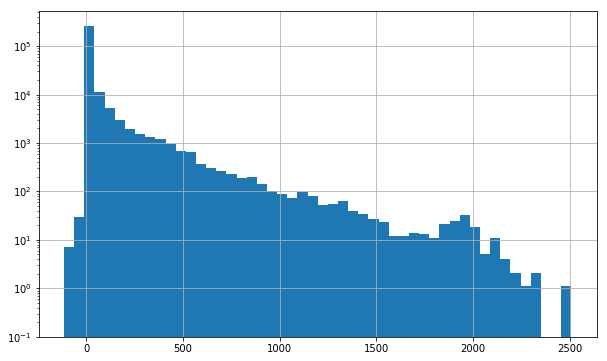

In [11]:
service_requests['time_to_close'].astype('timedelta64[D]').hist(bins=50, bottom=0.1)
plt.yscale('log')

In [12]:
service_requests['time_to_close'].mean()

Timedelta('30 days 11:23:32.672909')

The time to close has a mean of a month, but we can see that there are still quite a few that take longer. How about we look at these values over the different neighborhoods? First, we need to convert the time delta data types to something more useful (i.e., that won't break pandas):

In [13]:
service_requests.loc[:, 'time_to_close'] = service_requests['time_to_close'].astype('timedelta64[D]')

Let's look at the top 10 neighborhoods in their wait time:

In [14]:
(service_requests.groupby('neighborhood')[['time_to_close']]
                 .mean()
                 .sort_values('time_to_close', ascending=False)
)[:10]

,time_to_close
neighborhood,
Crocker Highland,83.522924
Lakeshore,80.091507
Panoramic Hill,68.520661
Rockridge,67.583084
Upper Rockridge,64.685569
Glen Highlands,61.854914
Montclair Business,61.584670
Merriwood,60.861976
Trestle Glen,59.825352


And now the bottom 10 (i.e., with the fastest response):

In [15]:
(service_requests.groupby('neighborhood')[['time_to_close']]
                 .mean()
                 .sort_values('time_to_close', ascending=True)
)[:10]

,time_to_close
neighborhood,
South Stonehurst,8.633527
McClymonds,11.034345
Melrose,12.997396
Clawson,13.664006
Highland,13.750863
Fremont,14.479876
Oak Tree,14.539823
Hoover/ Foster,14.945067
Seminary,15.404915


Let's get a map of these to get a sense of how these are geospatially distributed. To do this, let's overlay the neighborhoods on top of a map, and color code the neighborhoods based on their mean time to close.

In [16]:
mean_time_to_close = service_requests.groupby('neighborhood')['time_to_close'].mean()

In [17]:
neighborhoods = neighborhoods.join(mean_time_to_close, on='name')

In [18]:
neighborhoods.head()

,name,description,geometry,time_to_close
0,Acorn/ Acorn Industrial,,POINT (-122.308714010677 37.802146145243),33.304501
1,Adams Point,,POINT (-122.254661526017 37.8121177617939),29.097398
2,Allendale,,POINT (-122.203566466228 37.7871405525981),23.385798
3,Arroyo Viejo,,POINT (-122.178464360722 37.7600613799457),19.281956
4,Bancroft Business/ Havenscourt,,POINT (-122.184941350471 37.7669285553085),21.010000


https://ocefpaf.github.io/python4oceanographers/blog/2015/08/24/choropleth/

Longitude range:  (-122.35304219896193, -122.10048551341704)
Latitude range:  (37.68944924029288, 37.894234908415413)


/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


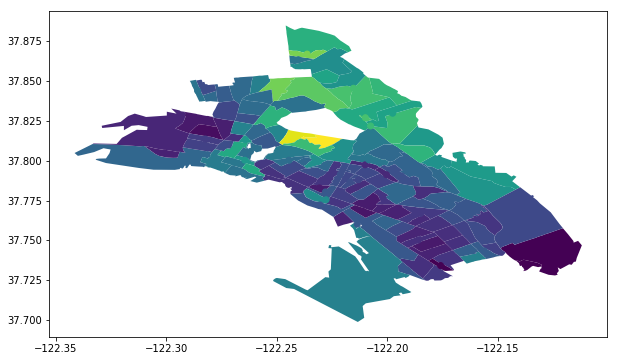

In [23]:
f, ax = plt.subplots()
neighborhoods.plot(column='time_to_close', ax=ax)

print('Longitude range: ', ax.get_xlim())
print('Latitude range: ', ax.get_ylim())

# Get the limits of our map
llcrnrlon, urcrnrlon = ax.get_xlim()
llcrnrlat, urcrnrlat = ax.get_ylim()

/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


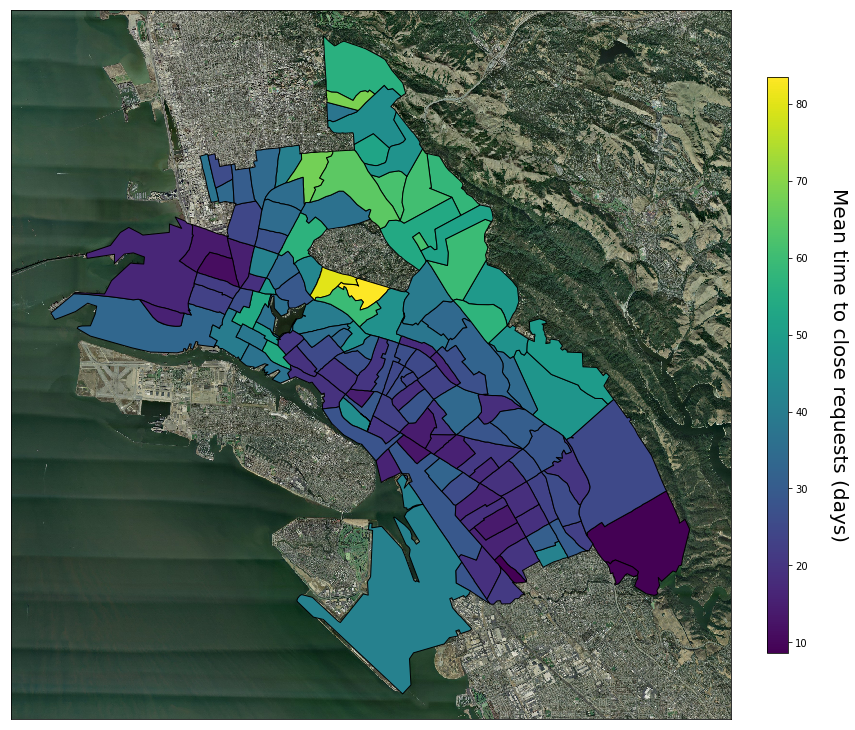

In [30]:
# Create a canvas
f = plt.figure(figsize=(10,10))
ax = f.add_axes([0.,0.,1.,1.])
    
# Create a map
bm = Basemap(epsg=3493,
             llcrnrlon=llcrnrlon,
             llcrnrlat=llcrnrlat,
             urcrnrlon=urcrnrlon,
             urcrnrlat=urcrnrlat,
             ax=ax)

bm.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=2000)

# Plot the neighborhoods
patches = []

for poly in neighborhoods.geometry:
    for subpoly in poly:
        mpoly = shapely.ops.transform(bm, poly)
        patches.append(PolygonPatch(mpoly))

pc = PatchCollection(patches, match_original=True)

# Color code these patches based on the time_to_close of that neighborhood
pc.set_array(neighborhoods['time_to_close'].values)
pc.set_clim([neighborhoods['time_to_close'].min(), neighborhoods['time_to_close'].max()])


ax.add_collection(pc)

# Create a color bar
cax = f.add_axes([1.05, 0.1, 0.03, 0.8])
cbar = f.colorbar(pc, cax=cax)
cbar.set_label('Mean time to close requests (days)', rotation=270, labelpad=40, fontsize=20)

## Time between opening request and now* for open requests
- The above analysis only looks at closed requests, meaning we would be missing any that have been open for a long time. Let's look at how these lingering issues are distributed

In [31]:
service_requests.loc[:, 'time_since_init'] = service_requests['time_since_init'].astype('timedelta64[D]')

In [ ]:
(service_requests[service_requests['STATUS'] == 'OPEN'].groupby('neighborhood')['time_since_init']
                                                       .mean()
                                                       .sort_values(ascending=False))[:10]

In [ ]:
(service_requests[service_requests['STATUS'] == 'OPEN'].groupby('neighborhood')['time_since_init']
                                                       .mean()
                                                       .sort_values(ascending=True))[:10]

In [ ]:
mean_time_since_init = service_requests[service_requests['STATUS'] == 'OPEN'].groupby('neighborhood')['time_since_init'].mean()

In [ ]:
neighborhoods = neighborhoods.join(mean_time_since_init, on='name')

In [ ]:
# Create a canvas
f = plt.figure(figsize=(10,10))
ax = f.add_axes([0.,0.,1.,1.])
    
# Create a map
bm = Basemap(epsg=3493,
             llcrnrlon=llcrnrlon,
             llcrnrlat=llcrnrlat,
             urcrnrlon=urcrnrlon,
             urcrnrlat=urcrnrlat,
             ax=ax)

bm.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=2000)

# Plot the neighborhoods
patches = []

for poly in neighborhoods.geometry:
    for subpoly in poly:
        mpoly = shapely.ops.transform(bm, poly)
        patches.append(PolygonPatch(mpoly))

pc = PatchCollection(patches, match_original=True)

# Color code these patches based on the time_to_close of that neighborhood
pc.set_array(neighborhoods['time_since_init'].values)
pc.set_clim([neighborhoods['time_since_init'].min(), neighborhoods['time_since_init'].max()])


ax.add_collection(pc)

# Create a color bar
cax = f.add_axes([1.05, 0.1, 0.03, 0.8])
cbar = f.colorbar(pc, cax=cax)
cbar.set_label('Mean time since request opened (days)', rotation=270, labelpad=40, fontsize=20)

Well, these seem somewhat interesting, but I'm still only looking at all requests, which we don't expect to be uniform. Let's start looking at specific types of requests:

In [ ]:
service_requests['REQCATEGORY'].unique()

In [ ]:
def counts_in_neighborhood(category):
    n_category = service_requests[service_requests['REQCATEGORY'] == category].groupby('neighborhood')['REQUESTID'].count()
    n_category.rename(f'N_{category}', inplace=True)
    return n_category

## Grafitti

In [ ]:
n_graffiti = counts_in_neighborhood('GRAFFITI')

In [ ]:
neighborhoods = neighborhoods.join(n_graffiti, on='name')

In [ ]:
# Create a canvas
f = plt.figure(figsize=(10,10))
ax = f.add_axes([0.,0.,1.,1.])
    
# Create a map
bm = Basemap(epsg=3493,
             llcrnrlon=llcrnrlon,
             llcrnrlat=llcrnrlat,
             urcrnrlon=urcrnrlon,
             urcrnrlat=urcrnrlat,
             ax=ax)

bm.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=2000)

# Plot the neighborhoods
patches = []

for poly in neighborhoods.geometry:
    for subpoly in poly:
        mpoly = shapely.ops.transform(bm, poly)
        patches.append(PolygonPatch(mpoly))

pc = PatchCollection(patches, match_original=True)

# Color code these patches based on the time_to_close of that neighborhood
pc.set_array(neighborhoods['N_GRAFFITI'].values)
pc.set_clim([neighborhoods['N_GRAFFITI'].min(), neighborhoods['N_GRAFFITI'].max()])


ax.add_collection(pc)

# Create a color bar
cax = f.add_axes([1.05, 0.1, 0.03, 0.8])
cbar = f.colorbar(pc, cax=cax)
cbar.set_label('Total number of grafitti removal requests', rotation=270, labelpad=40, fontsize=20)

## Illegal dumping

In [ ]:
n_dump = counts_in_neighborhood('ILLDUMP')
neighborhoods = neighborhoods.join(n_dump, on='name')

In [ ]:
# Create a canvas
f = plt.figure(figsize=(10,10))
ax = f.add_axes([0.,0.,1.,1.])
    
# Create a map
bm = Basemap(epsg=3493,
             llcrnrlon=llcrnrlon,
             llcrnrlat=llcrnrlat,
             urcrnrlon=urcrnrlon,
             urcrnrlat=urcrnrlat,
             ax=ax)

bm.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=2000)

# Plot the neighborhoods
patches = []

for poly in neighborhoods.geometry:
    for subpoly in poly:
        mpoly = shapely.ops.transform(bm, poly)
        patches.append(PolygonPatch(mpoly))

pc = PatchCollection(patches, match_original=True)

# Color code these patches based on the time_to_close of that neighborhood
pc.set_array(neighborhoods['N_ILLDUMP'].values)
pc.set_clim([neighborhoods['N_ILLDUMP'].min(), neighborhoods['N_ILLDUMP'].max()])


ax.add_collection(pc)

# Create a color bar
cax = f.add_axes([1.05, 0.1, 0.03, 0.8])
cbar = f.colorbar(pc, cax=cax)
cbar.set_label('Total number of illegal dumping removal requests', rotation=270, labelpad=40, fontsize=20)

In [ ]:
n_abandoned_autos = service_requests[service_requests['DESCRIPTION'] == 'Oakland Police - Abandoned Auto'].groupby('neighborhood')['REQUESTID'].count()

In [ ]:
n_abandoned_autos.rename('n_abandoned_autos', inplace=True)

In [ ]:
neighborhoods = neighborhoods.join(n_abandoned_autos, on='name')

In [ ]:
# Create a canvas
f = plt.figure(figsize=(10,10))
ax = f.add_axes([0.,0.,1.,1.])
    
# Create a map
bm = Basemap(epsg=3493,
             llcrnrlon=llcrnrlon,
             llcrnrlat=llcrnrlat,
             urcrnrlon=urcrnrlon,
             urcrnrlat=urcrnrlat,
             ax=ax)

bm.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=2000)

# Plot the neighborhoods
patches = []

for poly in neighborhoods.geometry:
    for subpoly in poly:
        mpoly = shapely.ops.transform(bm, poly)
        patches.append(PolygonPatch(mpoly))

pc = PatchCollection(patches, match_original=True)

# Color code these patches based on the time_to_close of that neighborhood
pc.set_array(neighborhoods['n_abandoned_autos'].values)
pc.set_clim([neighborhoods['n_abandoned_autos'].min(), neighborhoods['n_abandoned_autos'].max()])


ax.add_collection(pc)

# Create a color bar
cax = f.add_axes([1.05, 0.1, 0.03, 0.8])
cbar = f.colorbar(pc, cax=cax)
cbar.set_label('Total number of abandoned car removal requests', rotation=270, labelpad=40, fontsize=20)

Others of interest:
Homeless Encampment

In [19]:
poop = service_requests[service_requests['DESCRIPTION'] == 'Human Waste in Public-Right-of-Way'].groupby('neighborhood')['REQUESTID'].count()

In [20]:
poop.rename('n_poop', inplace=True)

neighborhood
Acorn/ Acorn Industrial                   5
Adams Point                              12
Allendale                                 2
Arroyo Viejo                             39
Bancroft Business/ Havenscourt           18
Brookfield Village                        9
Bushrod                                   6
CONFLICT                                  6
Castlemont                                9
Chinatown                                 8
Civic Center                             11
Claremont                                 1
Clawson                                  82
Cleveland Heights                         3
Clinton                                   1
Coliseum                                  5
Coliseum Industrial                      20
Columbia Gardens                          1
Cox                                       9
Crestmont                                 1
Crocker Highland                          1
Dimond                                    6
Downtown           

In [21]:
neighborhoods = neighborhoods.join(poop, on='name')

/Users/kjbilton/Installs/miniconda2/envs/oakland/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


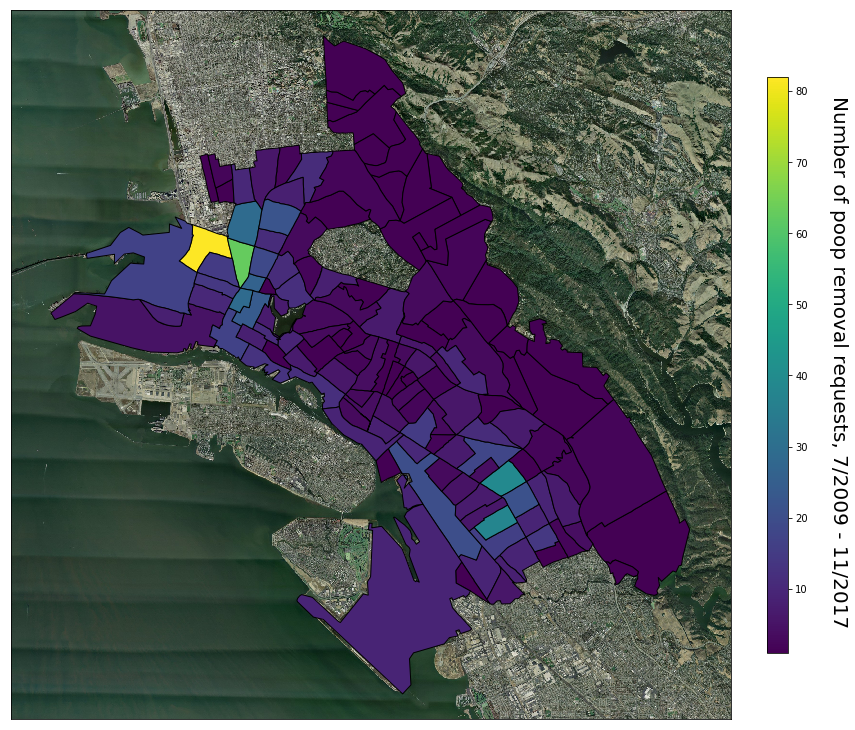

In [32]:
# Create a canvas
f = plt.figure(figsize=(10,10))
ax = f.add_axes([0.,0.,1.,1.])
    
# Create a map
bm = Basemap(epsg=3493,
             llcrnrlon=llcrnrlon,
             llcrnrlat=llcrnrlat,
             urcrnrlon=urcrnrlon,
             urcrnrlat=urcrnrlat,
             ax=ax)

bm.arcgisimage(service='ESRI_Imagery_World_2D', xpixels=2000)

# Plot the neighborhoods
patches = []

for poly in neighborhoods.geometry:
    for subpoly in poly:
        mpoly = shapely.ops.transform(bm, poly)
        patches.append(PolygonPatch(mpoly))

pc = PatchCollection(patches, match_original=True)

# Color code these patches based on the time_to_close of that neighborhood
pc.set_array(neighborhoods['n_poop'].values)
pc.set_clim([neighborhoods['n_poop'].min(), neighborhoods['n_poop'].max()])


ax.add_collection(pc)

# Create a color bar
cax = f.add_axes([1.05, 0.1, 0.03, 0.8])
cbar = f.colorbar(pc, cax=cax)
cbar.set_label('Number of poop removal requests, 7/2009 - 11/2017 ', rotation=270, labelpad=40, fontsize=20)

In [ ]:
service_requests[service_requests['DESCRIPTION'] == 'Human Waste in Public-Right-of-Way'].group

In [39]:
neighborhoods.sort_values(by='n_poop', ascending=True)[:10]

,name,description,geometry,time_to_close,n_poop
202,Lynn/ Highland Park,,"(POLYGON ((-122.22753834027 37.8000417020808, ...",45.923459,1.0
199,Lincoln Highlands,,"(POLYGON ((-122.192815158221 37.8051444165726,...",33.935638,1.0
207,Merriwood,,"(POLYGON ((-122.207092581319 37.8422724686209,...",60.861976,1.0
208,Merriwood,,"(POLYGON ((-122.21529784386 37.845453416317, -...",60.861976,1.0
178,Gaskill,,"(POLYGON ((-122.276807436049 37.8370039119494,...",34.344503,1.0
220,Not Named3,,"(POLYGON ((-122.194419205567 37.8106722733571,...",48.864151,1.0
233,Patten,,"(POLYGON ((-122.215446947553 37.7907369037009,...",24.822115,1.0
161,Crocker Highland,,"(POLYGON ((-122.221157097948 37.8133733126687,...",83.522924,1.0
160,Crestmont,,"(POLYGON ((-122.18511090475 37.798527563446, -...",46.404181,1.0
158,Columbia Gardens,,"(POLYGON ((-122.184322731492 37.7254697101049,...",28.374732,1.0
